## **IMPORTS**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Environment Setup & Dependencies**


In [1]:
import os
# Force pure python implementation to fix the "Descriptors" error
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION (UPDATED) ---
# Now pointing to the separate 'split_dataset' folders
TRAIN_DIR = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\split_dataset\train" 
TEST_DIR = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\split_dataset\test"

MODEL_SAVE_PATH = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\final_model.h5"
GRAPH_SAVE_PATH = r"C:\Users\evang\Downloads\Pen_vs_Pencil_Project\accuracy_graph.png"

# --- REQUIREMENTS ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 25  # Updated to 25 to help the graph settle

c:\Users\evang\anaconda3\envs\tensorflow_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\evang\anaconda3\envs\tensorflow_env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## **PHASE 1**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Prepare Data**

In [2]:
# --- DATA GENERATORS ---

# 1. TRAIN GENERATOR (Hard Mode)
# We removed 'validation_split' because we now have a physical 'train' folder.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # High rotation for better learning
    width_shift_range=0.2,   
    height_shift_range=0.2, 
    zoom_range=0.2,         
    shear_range=0.2,         
    horizontal_flip=True,
    fill_mode='nearest'    
)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,              # <--- Points to 'split_dataset/train'
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',       
    shuffle=True,
    seed=42
)

# 2. VALIDATION GENERATOR (Easy Mode)
# Uses the separate 'test' folder. Only rescaling (no twisting).
test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Validation Data...")
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,               # <--- Points to 'split_dataset/test'
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,          # Don't shuffle validation data
    seed=42
)

Loading Training Data...
Found 320 images belonging to 2 classes.
Loading Validation Data...
Found 80 images belonging to 2 classes.


## **PHASE 2**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Build CNN Model**

In [3]:
model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(2, 2),


    # The Brain
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    # CRITICAL: This layer forces the lines to stick together
    tf.keras.layers.Dropout(0.5), 

    tf.keras.layers.Dense(1, activation='sigmoid')
])

## **PHASE 3**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Compile and Train**

In [4]:
# Requirement: Adam, Binary Crossentropy, Accuracy
model.compile(
    # We use 0.0005 (Standard Adam is usually 0.001). 
    # This slightly slower speed creates SMOOTHER graphs.
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

print(f"\nStarting Training ({EPOCHS} Epochs)...")

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS, # Requirement: 10-15 Epochs
    callbacks=[checkpoint]
)


Starting Training (25 Epochs)...
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 3.3341 - accuracy: 0.4719
Epoch 1: val_accuracy improved from -inf to 0.58750, saving model to C:\Users\evang\Downloads\Pen_vs_Pencil_Project\final_model.h5
10/10 [==============================] - 10s 956ms/step - loss: 3.3341 - accuracy: 0.4719 - val_loss: 0.6604 - val_accuracy: 0.5875
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.6062
Epoch 2: val_accuracy did not improve from 0.58750
10/10 [==============================] - 3s 296ms/step - loss: 0.6659 - accuracy: 0.6062 - val_loss: 0.6153 - val_accuracy: 0.5000
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6500
Epoch 3: val_accuracy did not improve from 0.58750
10/10 [==============================] - 4s 367ms/step - loss: 0.6232 - accuracy: 0.6500 - val_loss: 0.5691 - val_accuracy: 0.5125
Epoch 4/25
10/10 [==============================] - ETA: 

## **PHASE 4**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Graph Results**

Graph saved to C:\Users\evang\Downloads\Pen_vs_Pencil_Project\accuracy_graph.png


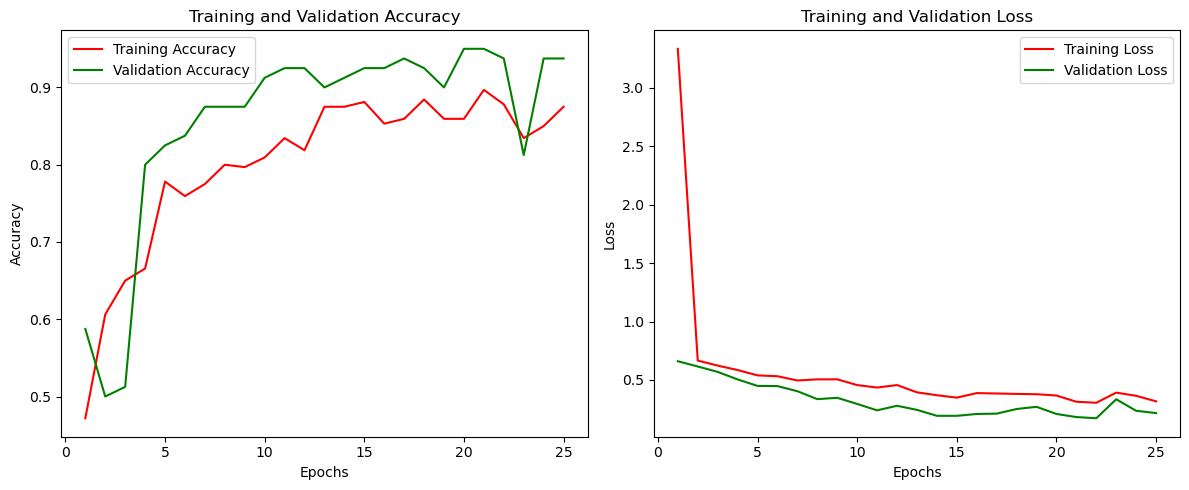

In [5]:
import matplotlib.pyplot as plt

# Get metrics
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
epochs_range = range(1, len(acc)+1)

# Create figure
plt.figure(figsize=(12, 5))

# --- Accuracy subplot ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# --- Loss subplot ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save and show
plt.tight_layout()
plt.savefig(GRAPH_SAVE_PATH)
print(f"Graph saved to {GRAPH_SAVE_PATH}")
plt.show()

## **TEST MODEL INDIVIDUALLY**
<hr style="border: none; height: 3px; background: #e10600;">

1/1 [==============================] - 0s 83ms/step
------------------------------
PREDICTION: PENCIL
CONFIDENCE: 94.07%
------------------------------


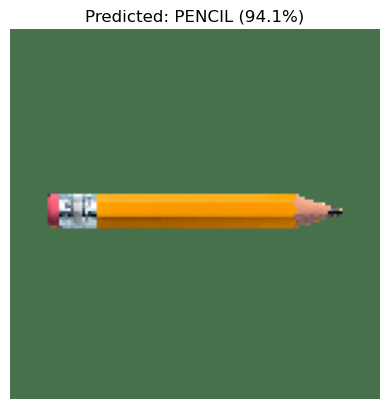

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Your specific image path
test_image_path = r"C:\Users\evang\Downloads\a-classic-yellow-number-two-pencil-sharpened-and-ready-for-writing-displayed-horizontally-png.png"
try:
    # Load image (128x128 as per PDF requirements)
    img = load_img(test_image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0 # Normalize 0-1

    # Predict
    prediction = model.predict(img_array)
    score = prediction[0][0] # Get the single probability value

    # Identify Class Names (0 vs 1)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    
    # Binary Classification Logic (Sigmoid)
    # < 0.5 = Class 0
    # > 0.5 = Class 1
    print("-" * 30)
    if score < 0.5:
        class_name = class_indices[0].upper()
        confidence = (1 - score) * 100
    else:
        class_name = class_indices[1].upper()
        confidence = score * 100

    print(f"PREDICTION: {class_name}")
    print(f"CONFIDENCE: {confidence:.2f}%")
    print("-" * 30)

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_name} ({confidence:.1f}%)")
    plt.show()

except Exception as e:
    print(f"Error: {e}")